In [1]:
import sys
from os.path import join, exists, abspath
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import h5py
import scipy
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nib
# import nitools as nt
import nilearn
from nilearn.plotting import plot_surf, view_img

In [3]:
print(nilearn.__version__)

0.11.1


In [4]:
# np.set_printoptions(linewidth=20)

In [5]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

---

In [6]:
dir_git = 'D:/mobaxterm/sungbeenpark/github'
dir_work = join(dir_git,'diedrichsenlab/SeqSpatialSupp_fMRI')
exists(dir_work)

True

In [7]:
dir_data = 'D:/milli/diedrichsenlab/SeqSpatialSupp_fMRI'
exists(dir_data)

True

In [8]:
path_module = abspath(join(dir_git,'nitools'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import nitools as nt

added the path, D:\mobaxterm\sungbeenpark\github\nitools


In [9]:
path_module = abspath(join(dir_git,'SUITPy'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import SUITPy as suit

added the path, D:\mobaxterm\sungbeenpark\github\SUITPy


In [10]:
path_module = abspath(dir_git)
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import surfAnalysisPy as surf

added the path, D:\mobaxterm\sungbeenpark\github


In [11]:
dir_atlas = join(dir_git,'diedrichsenlab/atlas/fs_LR_32k')
hemN = ['L','R']
print(exists(dir_atlas))
print(len(glob(join(dir_atlas,'*'))))

True
85


---

## Contrast

$$RDM = \begin{bmatrix}
\textcolor{gray}{B} & C & C & C & S & N & N & N \\
C & \textcolor{gray}{B} & C & C & N & S & N & N \\
C & C & \textcolor{gray}{B} & C & N & N & S & N \\
C & C & C & \textcolor{gray}{B} & N & N & N & S \\
S & N & N & N & \textcolor{gray}{B} & C & C & C \\
N & S & N & N & C & \textcolor{gray}{B} & C & C \\
N & N & S & N & C & C & \textcolor{gray}{B} & C \\
N & N & N & S & C & C & C & \textcolor{gray}{B}
\end{bmatrix}$$
The number of elements on the upper triangle $= \frac{8\cdot 7}{2} = 28$
1. B: both of cue and sequence repetition (8 trials)
2. S: only sequence repetition (8 trials)
3. C: only cue repetition (24 trials)
4. N: no repetition (24 trials)

- Conditions:
    1. MotorOnly-L (S)
    2. MotorOnly-S (S)
    3. CueOnly-L (C)
    4. CueOnly-S (C)
    5. BothRep-L (B)
    6. BothRep-S (B)
    7. NonRep-L (N)
    8. NonRep-S (N)
    9. Non-Interest

- Contrasts:
    1. BothRep-L:  $c=[0\ 0\ 0\ 0\ 1\ 0\ 0\ 0\ 0]$
    2. CueRep-L:   $c=[0\ 0\ 1\ 0\ 0\ 0\ 0\ 0\ 0]$
    3. MotorRep-L: $c=[1\ 0\ 0\ 0\ 0\ 0\ 0\ 0\ 0]$
    4. NRep-L:     $c=[0\ 0\ 0\ 0\ 0\ 0\ 1\ 0\ 0]$
    5. BothRep-S:  $c=[0\ 0\ 0\ 0\ 0\ 1\ 0\ 0\ 0]$
    6. CueRep-S:   $c=[0\ 0\ 0\ 1\ 0\ 0\ 0\ 0\ 0]$
    7. MotorRep-S: $c=[0\ 1\ 0\ 0\ 0\ 0\ 0\ 0\ 0]$
    8. NRep-S:     $c=[0\ 0\ 0\ 0\ 0\ 0\ 0\ 1\ 0]$
    9. wRS-L:      $c=[0\ 0\ \!-\!1\ 0\ 1\ 0\ 0\ 0\ 0]$
    10. wRS-S:     $c=[0\ 0\ 0\ \!-\!1\ 0\ 1\ 0\ 0\ 0]$
    11. wRS-L-S:   $c=[0\ 0\ \!-\!1\ \!-\!1\ 1\ 1\ 0\ 0\ 0]$
    12. acRS-L:    $c=[1\ 0\ 0\ 0\ 0\ 0\ \!-\!1\ 0\ 0]$
    13. acRS-S:    $c=[0\ 1\ 0\ 0\ 0\ 0\ 0\ \!-\!1\ 0]$
    14. acRS-L-S:  $c=[1\ 1\ 0\ 0\ 0\ 0\ \!-\!1\ \!-\!1\ 0]$
    15. Letter:    $c=[1\ 0\ 1\ 0\ 1\ 0\ 1\ 0\ 0]*0.25$
    16. Spatial:   $c=[0\ 1\ 0\ 1\ 0\ 1\ 0\ 1\ 0]*0.25$
    17. L-S:       $c=[1\ \!-\!1\ 1\ \!-\!1\ 1\ \!-\!1\ 1\ \!-\!1\ 0]$

- Calculation:
    $$ \vec{c}\cdot\vec{\beta}=d $$

In [12]:
dir_glm = join(dir_data,'glm_2')
exists(dir_glm)

True

In [14]:
list_cond = [
    'MotorOnly-L', 'MotorOnly-S', 'CueOnly-L', 'CueOnly-S', 'BothRep-L',
    'BothRep-S', 'NonRep-L', 'NonRep-S', 'Non-Interest'
]

In [15]:
list_contrast = [
    'BothRep-L', 'CueRep-L', 'MotorRep-L', 'NRep-L', 'BothRep-S',
    'CueRep-S', 'MotorRep-S', 'NRep-S', 'wRS-L', 'wRS-S',
    'wRS-L-S', 'acRS-L', 'acRS-S', 'acRS-L-S', 'Letter',
    'Spatial', 'Letter-Spatial'
]

---

## FreeSurfer

In [16]:
underlay = join(dir_atlas,'fs_LR.32k.LR.sulc.dscalar.gii')

In [17]:
glob(join(dir_atlas,'fs_LR*.L.*.gii'))

['D:/mobaxterm/sungbeenpark/github\\diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.flat.surf.gii',
 'D:/mobaxterm/sungbeenpark/github\\diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.inflated.surf.gii',
 'D:/mobaxterm/sungbeenpark/github\\diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.midthickness.surf.gii',
 'D:/mobaxterm/sungbeenpark/github\\diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.pial.surf.gii',
 'D:/mobaxterm/sungbeenpark/github\\diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.sphere.surf.gii',
 'D:/mobaxterm/sungbeenpark/github\\diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.surfArea.func.gii',
 'D:/mobaxterm/sungbeenpark/github\\diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.very_inflated.surf.gii',
 'D:/mobaxterm/sungbeenpark/github\\diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.white.surf.gii']

In [18]:
flatsurf = [] # Flat surface

for h,hem in enumerate(hemN):
    flatsurf.append(join(dir_atlas,'fs_LR.32k.' + hem + '.flat.surf.gii'))
flatsurf = sorted(flatsurf)
flatsurf

['D:/mobaxterm/sungbeenpark/github\\diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.L.flat.surf.gii',
 'D:/mobaxterm/sungbeenpark/github\\diedrichsenlab/atlas/fs_LR_32k\\fs_LR.32k.R.flat.surf.gii']

In [19]:
list_roi = ['SMA', 'PMv', 'PMd', 'M1', 'S1', 'SPLa', 'SPLp', 'DSVC', 'MT+', 'VSVC', 'EAC']

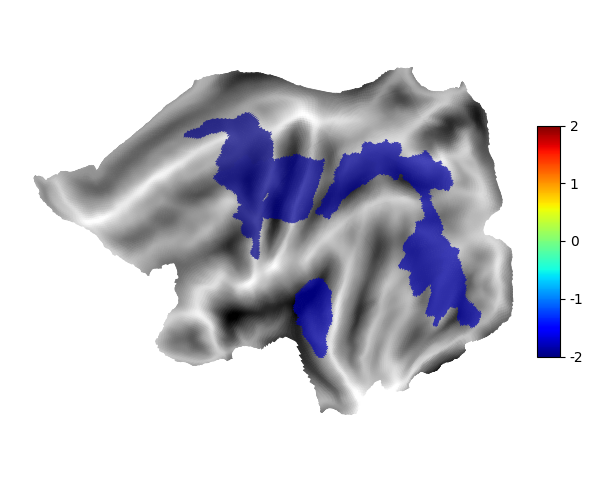

In [20]:
roi = nib.load(join(dir_atlas,'ROI.L.SSS.label.gii'))
data_roi = roi.darrays[0].data

fig = plt.figure(figsize=(8,6))
ax = surf.plot.plotmap(
    data=data_roi*(data_roi>0), underlay=underlay,
    surf=flatsurf[0], overlay_type='func', alpha=0.7,
    # borders=join(dir_atlas,'fs_LR.32k.L.border-IPS.border'), bordercolor='white', bordersize=3,
    cmap=cm.jet, colorbar=True, cscale=[-2,2]
    # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
)
# cols = nt.get_gifti_column_names(roi)
# print('column heads (%d):\n'%len(cols),cols)

<Axes: >

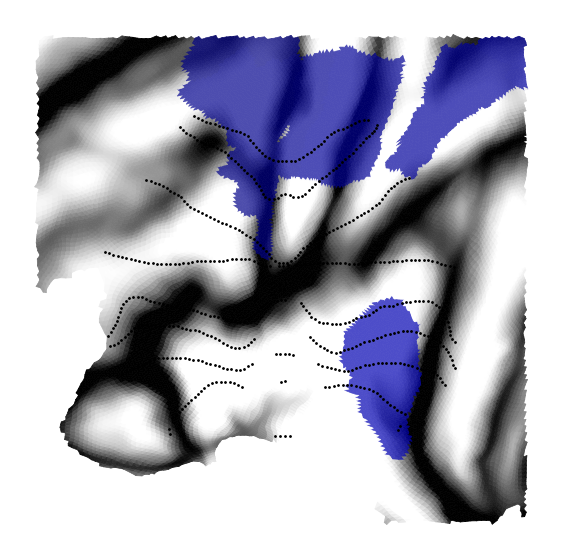

In [21]:
suit.flatmap.plot(
    data=data_roi, underlay=underlay,
    surf=flatsurf[0], overlay_type='func', alpha=0.7,
    cmap=cm.jet
)

---

## Repetition Suppression (GLM2)

In [22]:
dir_stat = join(dir_data,'surfaceWB/glm2/psc')
exists(dir_stat)

True

### Individual

In [23]:
new_line = []

In [24]:
subj = 'S01'
fname = glob(join(dir_stat,'%s.L.glm2.psc.func.gii'%subj))[0]
img = nib.load(fname)
for ii, contrast in enumerate(list_contrast):
    data = img.darrays[ii].data
    for jj, roi in enumerate(list_roi):
        new_line.append({
            'session':subj[0], 'subj':subj[1:],
            'contrast':contrast,
            'roi':roi,
            'psc':np.nanmean(data[data_roi==jj+1]),
        })
df = pd.DataFrame(new_line)
df

,session,subj,contrast,roi,psc
0,S,01,BothRep-L,SMA,0.150642
1,S,01,BothRep-L,PMv,0.444528
2,S,01,BothRep-L,PMd,0.485867
3,S,01,BothRep-L,M1,0.942630
4,S,01,BothRep-L,S1,0.389911
...,...,...,...,...,...
182,S,01,Letter-Spatial,SPLp,-0.902910
183,S,01,Letter-Spatial,DSVC,-0.601273
184,S,01,Letter-Spatial,MT+,0.075235
185,S,01,Letter-Spatial,VSVC,-0.247771


In [25]:
# data[abs(data)<0.001]=np.nan
data[data_roi<=0]=np.nan

(0.0, 20.0)

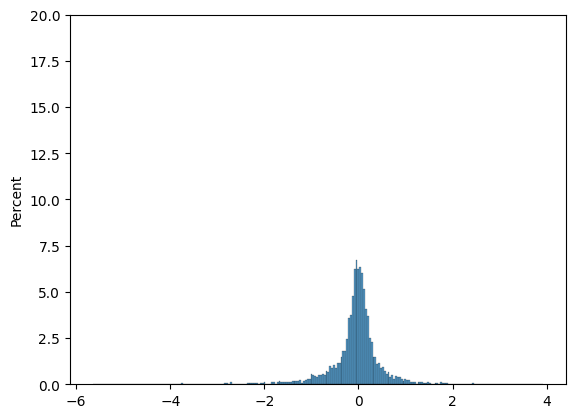

In [26]:
g = sns.histplot(data, stat='percent')
g.set_ylim(0,20)

<Axes: >

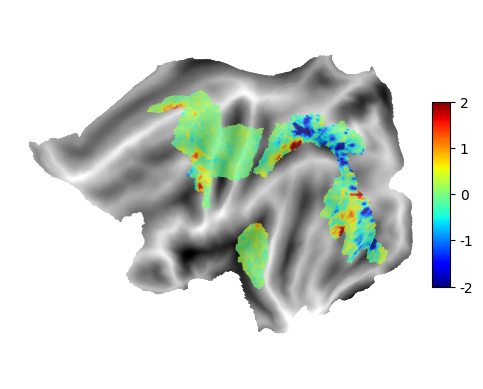

In [27]:
surf.plot.plotmap(
    data=data,
    surf=flatsurf[0], underlay=underlay, alpha=0.7,
    cmap=cm.jet, colorbar=True, cscale=[-2,2]
    # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
)

### Group

['S01', 'S02', 'S03', 'S05', 'S06', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14']
acRS-L
['R01', 'R02', 'R03', 'R05', 'R06', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
acRS-L
['S01', 'S02', 'S03', 'S05', 'S06', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14']
acRS-S
['R01', 'R02', 'R03', 'R05', 'R06', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
acRS-S
['S01', 'S02', 'S03', 'S05', 'S06', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14']
wRS-L
['R01', 'R02', 'R03', 'R05', 'R06', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
wRS-L
['S01', 'S02', 'S03', 'S05', 'S06', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14']
wRS-S
['R01', 'R02', 'R03', 'R05', 'R06', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
wRS-S


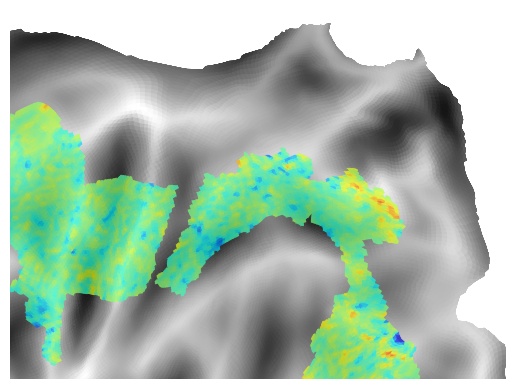

In [28]:
fig, ax = plt.subplots()

for stat in ['acRS-L','acRS-S','wRS-L','wRS-S']:
    for group in ['S_all','R_all']:
        fname = join(dir_stat,'group32k/group.%s.psc.L.glm2.%s.func.gii'%(group,stat))
        # fname = join(dir_stat,'group32k_opt/group.psc.L.glm2.%s.func.gii'%stat)
        # fname = join(dir_stat,'group32k_dur1/group.psc.L.glm2.%s.func.gii'%stat)
        img = nib.load(fname)
        cols = nt.get_gifti_column_names(img)
        print(cols)
        
        cmap = cm.jet
        
        for idx, feature in enumerate(cols):
            data = img.darrays[idx].data
            if idx == 0:
                data_group = data
            else:
                data_group += data
        data_group /= len(cols)
        
        ## thresholding
        # data_group[abs(data_group)<0.1] = np.nan
        data_group[data_roi<=0]=np.nan
        
        g = surf.plot.plotmap(
            data=data_group,
            surf=flatsurf[0], underlay=underlay, alpha=0.7,
            cmap=cmap, colorbar=False, cscale=[-0.5,0.5]
            # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
        )
        print(stat)
        # g.text(
        #     50,220,
        #     stat,
        #     fontsize=16,
        #     horizontalalignment='center', verticalalignment='center'
        # )
        
        ## 사각형으로 점선 그리기
        rect = patches.Rectangle((-40, 0), 280, 200, linewidth=2, edgecolor='k', facecolor='none', linestyle='--')
        ax.add_patch(rect)

        fig.savefig(
            join(dir_work,'results/fig.glm2.psc.RS_effect.%s.%s.whole.png'%(group,stat)),
            dpi=300, facecolor=[1,1,1,1],
            bbox_inches = "tight"
        )
        ## Zoom-in
        g.set_xlim(50,150)
        g.set_ylim(1,195)
        fig.savefig(
            join(dir_work,'results/fig.glm2.psc.RS_effect.%s.%s.zoom.png'%(group,stat)),
            dpi=300, facecolor=[1,1,1,1],
            bbox_inches = "tight"
        )

---

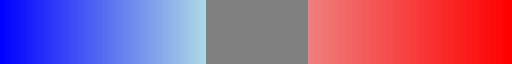

In [29]:
# 색상과 위치 정의 (그라디언트 적용)
color = [
    (0, 'blue'),        # 0에서 파란색 시작
    (0.4, 'lightblue'), # 0.3까지 점진적으로 밝은 파란색으로 변화
    (0.4, 'gray'),      # 0.3에서 회색 시작
    (0.6, 'gray'),      # 0.7까지 회색 유지
    (0.6, 'lightcoral'),# 0.7에서 밝은 빨간색 시작
    (1, 'red')          # 1에서 진한 빨간색으로 변화
]

# 사용자 정의 colormap 생성
cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', color)
cmap

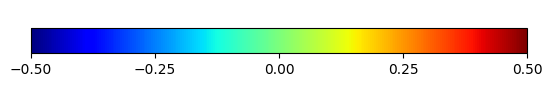

In [30]:
fig, ax = plt.subplots(1, 1)

fraction = 1  # .05

vmin, vmax = -0.5, 0.5
cmap=cm.jet

norm = colors.Normalize(vmin=vmin, vmax=vmax)
cbar = ax.figure.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, pad=.05, extend='neither', fraction=fraction,orientation='horizontal',
    ticks=[-0.5,-0.25,0,0.25,0.5]
)

ax.axis('off')
# plt.rcParams["figure.dpi"] = 300

plt.show()

fig.savefig(
    join(dir_work,'results/fig.colorbar.jet.[%.1f,%.1f].png'%(vmin,vmax)),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches = "tight"
)

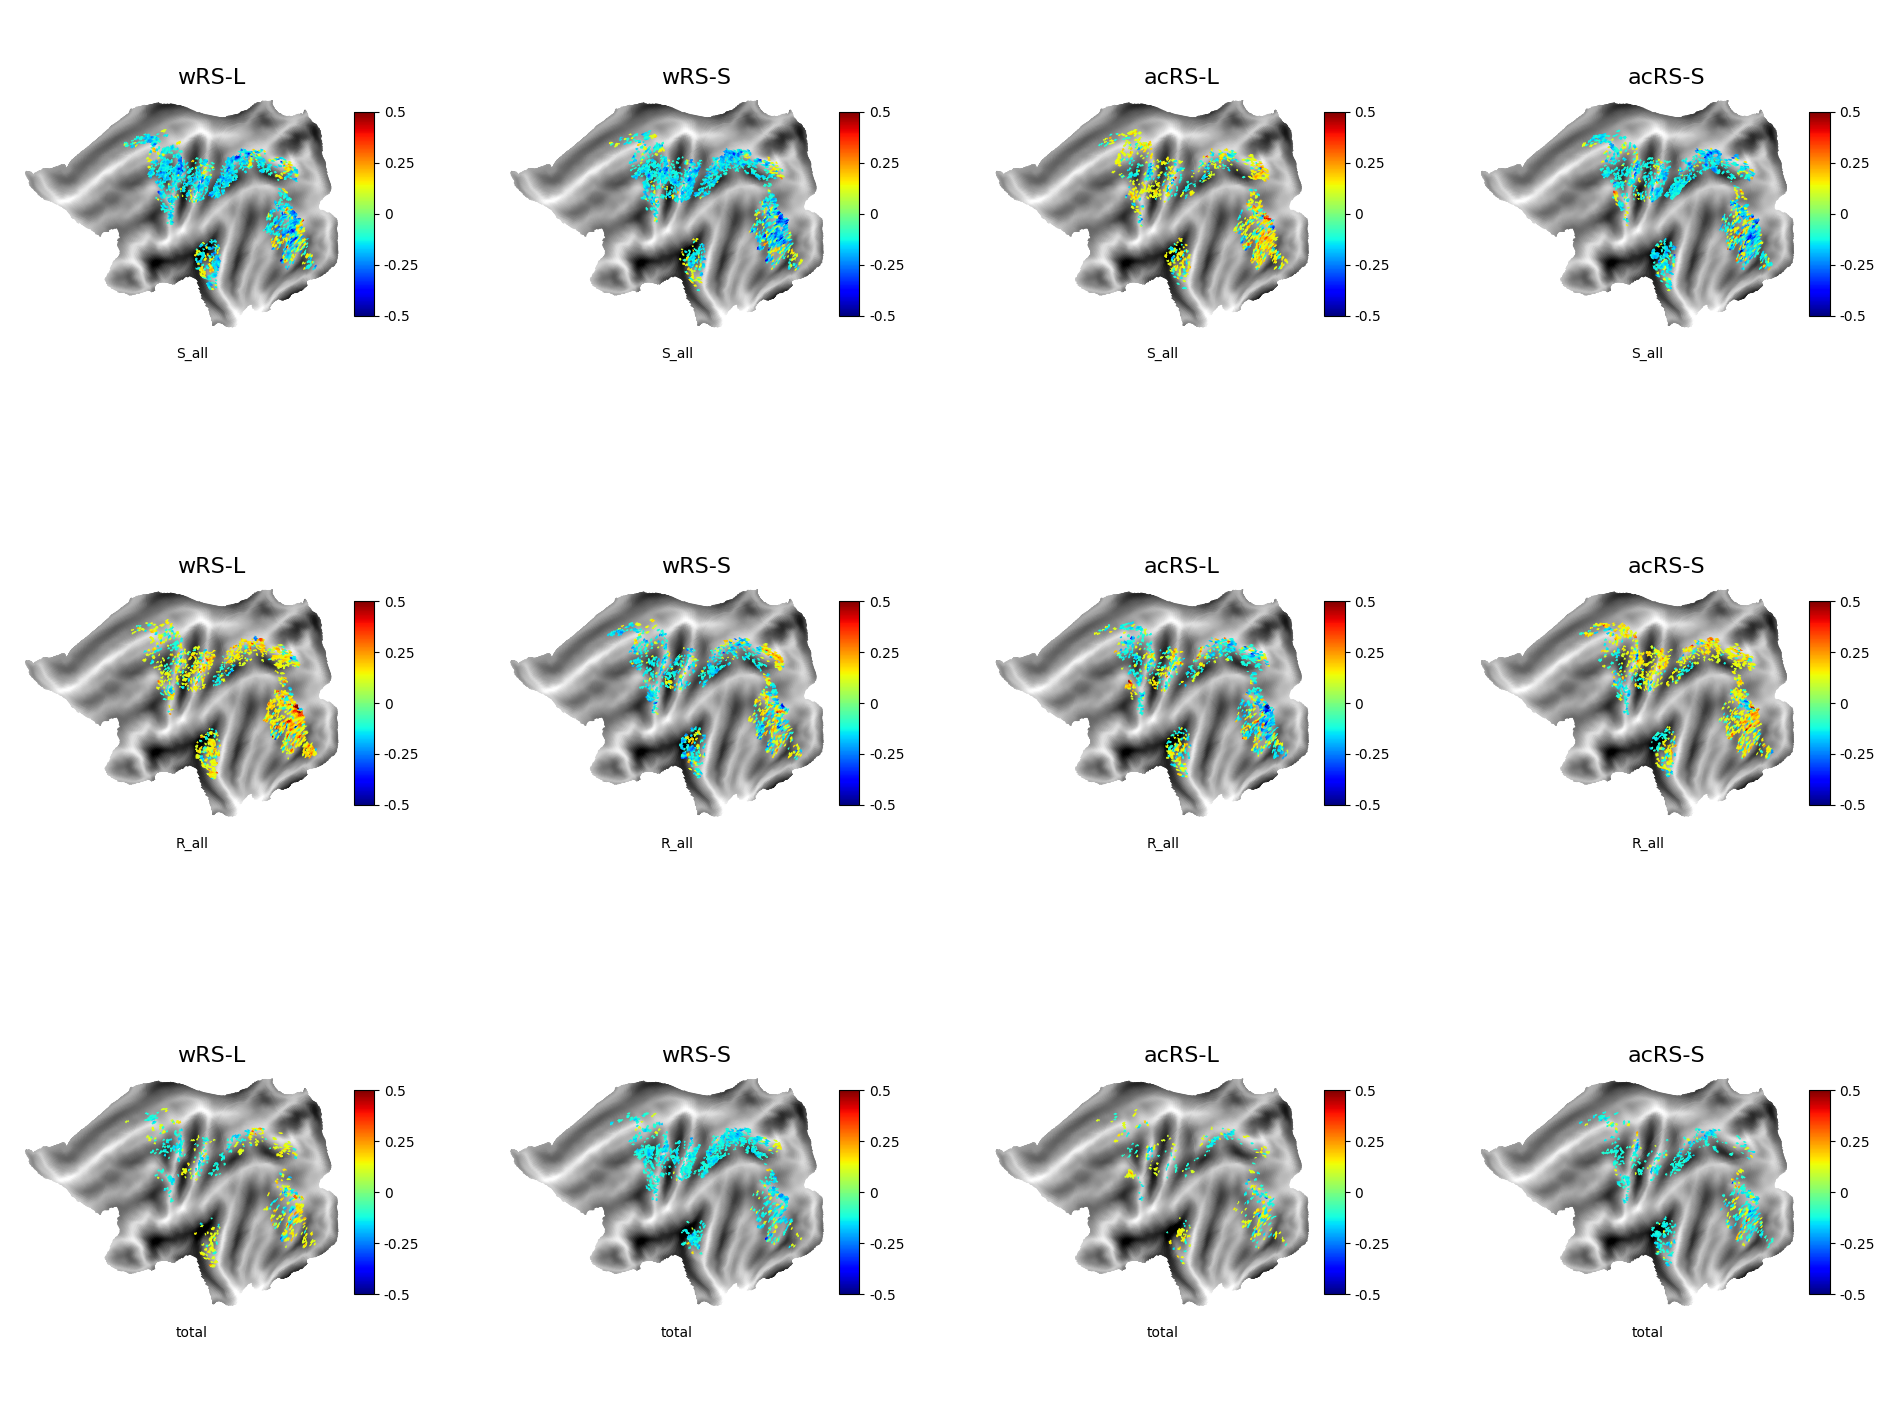

In [31]:
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,6*nrows))

for ss, stat in enumerate(['wRS-L','wRS-S','acRS-L','acRS-S']):
    for gg, group in enumerate(['S_all', 'R_all', 'total']):
        ax = axs[gg,ss]
        ## load data
        if not group=='total':
            # fname = join(dir_stat,'group32k_dur1/group.psc.L.glm2.%s.func.gii'%stat)
            fname = join(dir_stat,'group32k/group.%s.psc.L.glm2.%s.func.gii'%(group,stat))
        else:
            fname = join(dir_stat,'group32k_opt/group.psc.L.glm2.%s.func.gii'%stat)
        # exists(fname)
        img = nib.load(fname)
        cols = nt.get_gifti_column_names(img)
        # print('column heads (%d):\n'%len(cols),cols)
        
        # feature = 'R08'
        # idx = nt.get_gifti_column_names(img).index(feature)
        
        for idx, feature in enumerate(cols):
            data = img.darrays[idx].data
            # array = data.copy()
            # mean = np.mean(array)
            # std = np.std(array)
            # data_normalized = (array - mean) / std
            if idx == 0:
                # data_group = data_normalized
                data_group = data
            else:
                # data_group += data_normalized
                data_group += data
        data_group /= len(cols)

        ## thresholding
        data_group[abs(data_group)<0.1] = np.nan
        data_group[data_roi<=0] = np.nan
        
        plt.sca(ax)
        g = surf.plot.plotmap(
            data=data_group,
            surf=flatsurf[0], underlay=underlay,
            cmap=cm.jet, colorbar=True, cscale=[-0.5,0.5]
            # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
        )
        g.text(0,-180, group, fontsize=10)
        g.text(
            50,220,
            stat,
            fontsize=16,
            horizontalalignment='center', verticalalignment='center'
        )

In [36]:
fig.savefig(
    join(dir_work,'results/fig.glm2.psc.RS_effect.png'),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches = "tight"
)

---

### T-test

In [23]:
list_contrast

['BothRep-L',
 'CueRep-L',
 'MotorRep-L',
 'NRep-L',
 'BothRep-S',
 'CueRep-S',
 'MotorRep-S',
 'NRep-S',
 'wRS-L',
 'wRS-S',
 'wRS-L-S',
 'acRS-L',
 'acRS-S',
 'acRS-L-S',
 'Letter',
 'Spatial',
 'Letter-Spatial']

In [24]:
list_nn = [
    '01', '02', '03', '05', '06',
    '08', '09', '10', '11', '12', 
    '13', '14'
]

In [25]:
new_line = []

for ss in ['S','R']:
    for nn in list_nn:
        subj = ss+nn
        fname = join(dir_stat,'%s.L.glm2.psc.func.gii'%subj)
        img = nib.load(fname)
        for ii, contrast in enumerate(list_contrast):
            data = img.darrays[ii].data
            for jj, roi in enumerate(list_roi):
                new_line.append({
                    'session':ss, 'subj':nn,
                    'contrast':contrast,
                    'roi':roi,
                    'psc':np.nanmean(data[data_roi==jj+1]),
                })
df = pd.DataFrame(new_line)
df

,session,subj,contrast,roi,psc
0,S,01,BothRep-L,SMA,0.150642
1,S,01,BothRep-L,PMv,0.444528
2,S,01,BothRep-L,PMd,0.485867
3,S,01,BothRep-L,M1,0.942630
4,S,01,BothRep-L,S1,0.389911
...,...,...,...,...,...
4483,R,14,Letter-Spatial,SPLp,-0.252467
4484,R,14,Letter-Spatial,DSVC,-0.154465
4485,R,14,Letter-Spatial,MT+,0.014401
4486,R,14,Letter-Spatial,VSVC,0.001282


SMA
wRS-L
t(11)=-1.1492, nsp=0.2748
wRS-S
t(11)=-0.0150, nsp=0.9883
acRS-L
t(11)=1.0256, nsp=0.3271
acRS-S
t(11)=-1.0220, nsp=0.3287
PMv
wRS-L
t(11)=-1.4913, nsp=0.1640
wRS-S
t(11)=0.3465, nsp=0.7355
acRS-L
t(11)=0.1934, nsp=0.8502
acRS-S
t(11)=0.6816, nsp=0.5096
PMd
wRS-L
t(11)=-1.9664, nsp=0.0750
wRS-S
t(11)=-1.0076, nsp=0.3353
acRS-L
t(11)=0.3942, nsp=0.7009
acRS-S
t(11)=-1.0579, nsp=0.3128
M1
wRS-L
t(11)=-1.4730, nsp=0.1688
wRS-S
t(11)=-1.1371, nsp=0.2797
acRS-L
t(11)=0.4691, nsp=0.6482
acRS-S
t(11)=-1.2800, nsp=0.2269
S1
wRS-L
t(11)=-1.9810, nsp=0.0731
wRS-S
t(11)=-1.8201, nsp=0.0960
acRS-L
t(11)=0.0209, nsp=0.9837
acRS-S
t(11)=-1.8743, nsp=0.0877
SPLa
wRS-L
t(11)=-1.6187, nsp=0.1338
wRS-S
t(11)=-0.5528, nsp=0.5915
acRS-L
t(11)=0.0001, nsp=1.0000
acRS-S
t(11)=-1.4317, nsp=0.1800
SPLp
wRS-L
t(11)=-1.3158, nsp=0.2150
wRS-S
t(11)=-0.7558, nsp=0.4657
acRS-L
t(11)=0.4639, nsp=0.6517
acRS-S
t(11)=-1.6893, nsp=0.1193
DSVC
wRS-L
t(11)=-1.2248, nsp=0.2462
wRS-S
t(11)=-0.9180, nsp=0.3783
ac

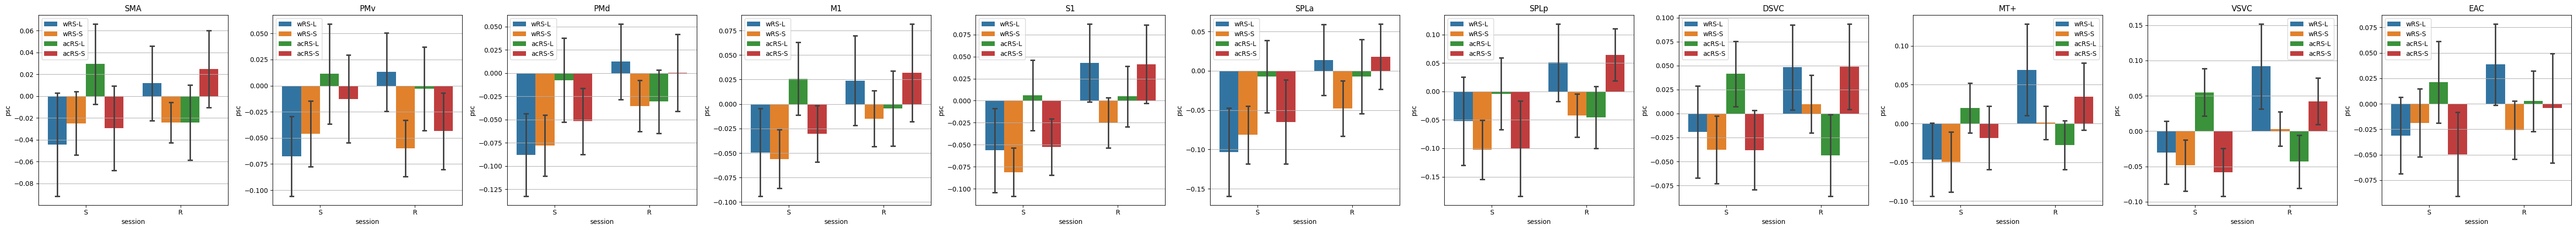

In [28]:
ncols = 11
fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*5,5))

for ii, roi in enumerate(list_roi):
    print(roi)
    ax = axs[ii]
    df_tmp = df[df.roi==roi]
    df_tmp = df_tmp[
        (df_tmp.contrast=='wRS-L')|(df_tmp.contrast=='wRS-S')|
        (df_tmp.contrast=='acRS-L')|(df_tmp.contrast=='acRS-S')
    ]
    # g = sns.pointplot(
    #     data=df_tmp,
    #     x='session', y='psc', hue='contrast',
    #     capsize=0.15, dodge=True,
    #     ax=ax
    # )
    g = sns.barplot(
        data=df_tmp,
        x='session', y='psc', hue='contrast',
        capsize=0.15, errorbar='se',
        ax=ax
    )
    # if ii == 0:
    #     ax.legend(
    #         bbox_to_anchor=(-0.6, 1), loc='upper left', borderaxespad=0
    #     )
    # else:
    #     ax.legend().remove()
    ax.legend(loc='best')
    ax.grid(axis='y')
    ax.set_title(roi)

    ## t-test
    for cont in ['wRS-L','wRS-S','acRS-L','acRS-S']:
        print(cont)
        a = df_tmp[(df_tmp.contrast==cont)&(df_tmp.session=='S')].psc.astype(float)
        b = df_tmp[(df_tmp.contrast==cont)&(df_tmp.session=='R')].psc.astype(float)
        res = scipy.stats.ttest_rel(a,b)
        tval, pval = res
        dof = res.df
        print('t(%d)=%.4f, %sp=%.4f'%(dof,tval,convert_pvalue_to_asterisks(pval),pval))
    
fig.tight_layout()

In [29]:
fig.savefig(
    join(dir_work,'results/fig.glm2.psc.RS_effect.barplot.t-test.png'),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches = "tight"
)

In [ ]:
dy = np.diff(g.get_ylim())[0] * 0.075
for ss, sess in enumerate(['S','R']):
    print(sess)
    for cc, cond in enumerate(list_cond):
        print(cond)
        a = dg_tmp[(dg_tmp.sess==sess)&(dg_tmp.cond==cond)&(dg_tmp.seqType==0)][feature].astype(float)
        b = dg_tmp[(dg_tmp.sess==sess)&(dg_tmp.cond==cond)&(dg_tmp.seqType==1)][feature].astype(float)
        res = scipy.stats.ttest_rel(a,b)
        tval, pval = res
        dof = res.df
        print('t(%d)=%.4f, %sp=%.4f'%(dof,tval,convert_pvalue_to_asterisks(pval),pval))
        if pval < 0.05:
            x = 2*ss + 0.2*(cc-1.5)
            y1 = a.mean()+a.sem()+dy
            y2 = b.mean()+b.sem()+dy
            yU = max(y1,y2)+dy*(cc+1)
            color = palette[cc]
            g.plot([x,x],[y1,yU],linestyle='-',color=color)
            g.plot([x+1,x+1],[y2,yU],linestyle='-',color=color)
            g.plot([x,x+1],[yU,yU],linestyle='-',color=color)
            g.text(
                x+0.5, yU+dy*0.3,
                convert_pvalue_to_asterisks(pval), fontsize=14, color=color,
                ha='center', va='center',
            )
    print()
fig

---

In [102]:
def visualize_surface(data, contrast_name, pval, LR):
    # data : GiftiImage, e.g., nb.load(base_dir + '/surfaceWB/group32k/summary.L.glm2.psc.sm3.func.gii')
    # contrast_name : str, e.g., 'BothRep-L'
    # LR : left=0 or right=1
    m_idx = nt.get_gifti_column_names(data).index('mean_'+ contrast_name)
    t_idx = nt.get_gifti_column_names(data).index('t_'+ contrast_name)

    # if pval == 0.05:
    #     # calculate t-value for p=0.05 with DoF = 11 with two-tailed test
    #     thresh = 2.201
    # elif pval == 0.01:
    #     thresh = 3.106
    # elif pval == 0.005:
    #     thresh = 3.496
    # elif pval == 0.001:
    #     thresh = 4.437
    thresh = scipy.stats.t.isf(0.5*pval, df=11)
    
    # get the data
    data_surf = data.darrays[m_idx].data * (abs(data.darrays[t_idx].data) > thresh)
    surf.plot.plotmap(
        data=data_surf,
        surf=flatsurf[LR], underlay=underlay,
        alpha=1,
        cscale=[-3, 3], threshold=[-0.0001, 0.0001], colorbar=True,
    )

In [104]:
fname = join(dir_stat,'group32k_opt/summary.L.glm2.psc.sm3.func.gii')
exists(fname)

True

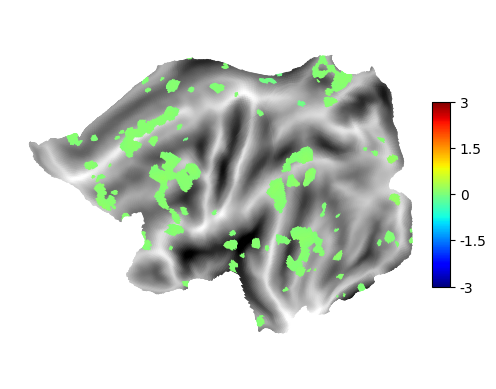

In [108]:
stat = 'acRS-L'
img = nb.load(fname)
visualize_surface(img,stat,0.05,0)

In [75]:
idx = nt.get_gifti_column_names(img).index('mean_%s'%stat)
data = img.darrays[idx].data
data.shape

(32492,)

<Axes: >

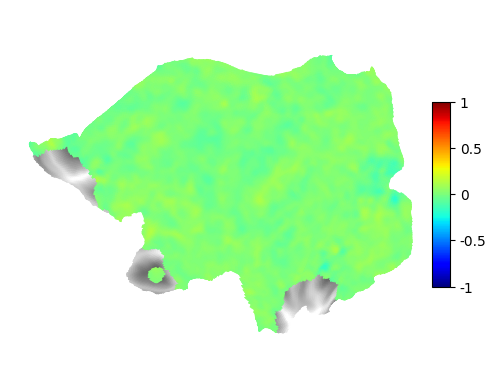

In [82]:
surf.plot.plotmap(
    data=data,
    surf=flatsurf[0], underlay=underlay,
    cmap=cm.jet, colorbar=True, cscale=[vmin,vmax],
    # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
)

In [88]:
nsubjects = 12
nvoxels = 32492 ## 32k
data = np.zeros((nsubjects, nvoxels))
pval = 0.05

In [90]:
stat = 'wRS-L'

# group = 'S_all'
# fname = join(dir_stat,'group32k/group.%s.psc.L.glm2.%s.func.gii'%(group,stat))

fname = join(dir_stat,'group32k_opt/group.psc.L.glm2.%s.func.gii'%stat)

img = nb.load(fname)

cols = nt.get_gifti_column_names(img)
for idx, feature in enumerate(cols):
    array = img.darrays[idx].data
    # mean = np.mean(array)
    # std = np.std(array)
    # data[idx,:] = (array - mean) / std
    data[idx,:] = array.copy()
res = scipy.stats.ttest_1samp(data, axis=0, popmean=0, alternative='two-sided')
thresh = scipy.stats.t.isf(0.5*pval, df=res.df[0])
print('upper tail probability:',thresh)

data_mean = data.mean(axis=0)

upper tail probability: 2.200985160082949


In [64]:
tval = res.statistic.copy()
print(tval.shape)
# data_mean *= (abs(tval) > thresh)
data_mean[abs(tval)<thresh] = np.nan
# tmp = abs(tmp[abs(tmp)>0.01])
# vmax = max(tmp.min(), tmp.max())
# vmin = -vmax
vmin, vmax = -1, 1
# cutline = tmp.min()
# print(vmin, vmax, cutline)
# min(data.mean(axis=0))

(32492,)


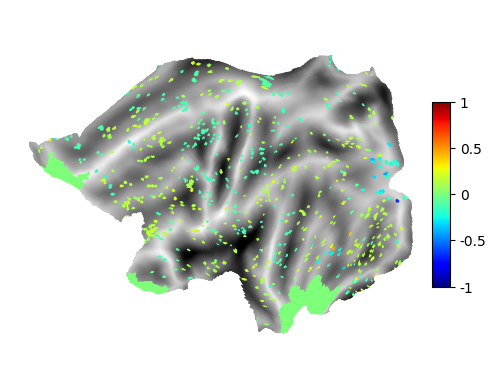

In [431]:
g = surf.plot.plotmap(
    data=data_mean,
    surf=flatsurf[0], underlay=underlay,
    cmap=cm.jet, colorbar=True, cscale=[vmin,vmax],
    # overlay_type='label', label_names=['SMA','PMv','PMd','M1','S1','aSPL','pSPL','DSVC']
)

In [90]:
fig.savefig(
    join(dir_work,'results/fig.glm2.psc.RS_effect.png'),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches = "tight"
)

---

## Smoothing

### Normal distribution

If the considered function is the density of a **normal distribution** of the form:
$$
f(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp{\Big[-\frac{(x-x_{0})^{2}}{2\sigma^{2}}\Big]}
$$
where $\sigma$ is the **standard deviation** and $x_{0}$ is the **expected value**, then the relationship between *full width at half maximum* (FWHM) and the standard deviation is:
$$
\text{FWHM}=2\sqrt{2\ln{2}}\sigma\approx2.355\sigma
$$

In [35]:
subj = 'S01'
fname = glob(join(dir_stat,'%s.L.glm2.psc.func.gii'%subj))[0]
fname
img = nb.load(fname)
cols = nt.get_gifti_column_names(img)
cols

['BothRep-L',
 'CueRep-L',
 'MotorRep-L',
 'NRep-L',
 'BothRep-S',
 'CueRep-S',
 'MotorRep-S',
 'NRep-S',
 'wRS-L',
 'wRS-S',
 'wRS-L-S',
 'acRS-L',
 'acRS-S',
 'acRS-L-S',
 'Letter',
 'Spatial',
 'Letter-Spatial']

In [37]:
img.darrays[0].data

array([ 0.00931335, -0.3850282 ,  0.74722946, ...,  0.13999757,
       -0.2937485 , -0.53004295], dtype=float32)

In [ ]:
scipy.ndimage.gaussian_filter(
    input=img.darrays[0].data,
    
)

D:/diedrichsenlab/SeqSpatialSupp_fMRI/surfaceWB/glm2/psc\group32k_dur1/summary.L.glm2.psc.sm3.func.gii


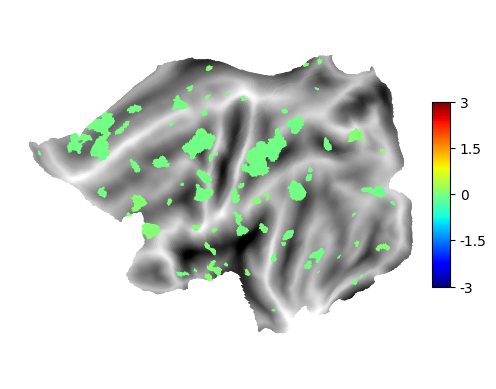

In [44]:
print(fname)
visualize_surface(img, 'wRS-L-S', pval=0.05, LR=0)

---